1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
Image 1: 3ba7daa0f72848e1940033de4c081afe_1-084_aug28.jpg
  Actual:    Benign
  Predicted: Benign (0.9994)


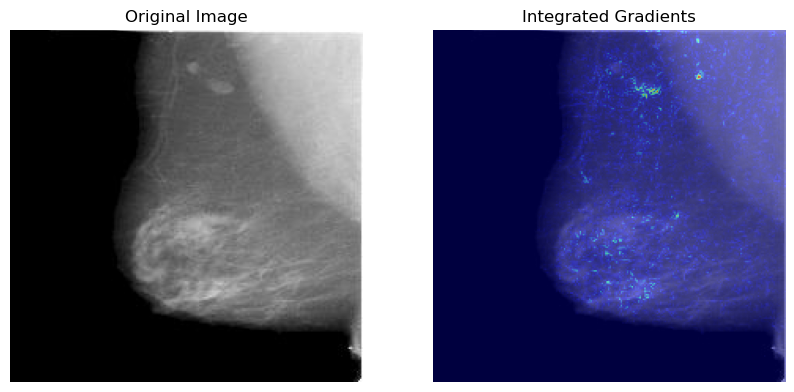

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Image 2: eab57cfe5e1d4acfb12496014600f50f_1-256_aug870.jpg
  Actual:    Benign
  Predicted: Benign (1.0000)


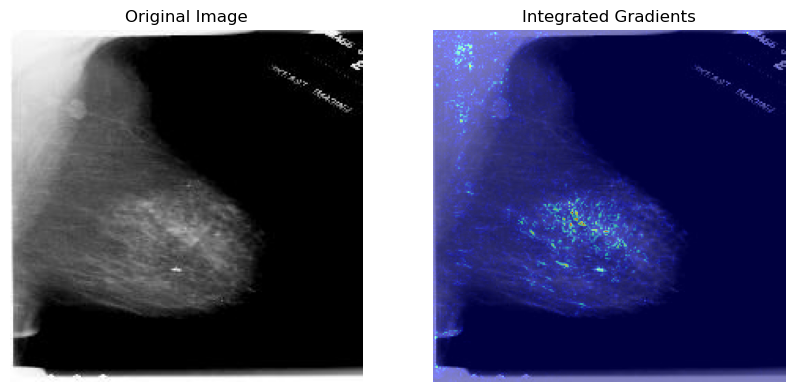

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import os
import random

# ========== CONFIG ==========
model_path = "pretrained_model/Resnet50.keras"
data_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images"
class_names = ["Benign", "Malignant"]
img_size = 224

# ===== LOAD MODEL =====
model = tf.keras.models.load_model(model_path)

# ===== LOAD RAW IMAGES =====
def load_images_from_folder(folder, max_images=5):
    image_paths = []
    for root, _, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, fname))
    selected_paths = random.sample(image_paths, min(max_images, len(image_paths)))
    images = []
    for path in selected_paths:
        img = image.load_img(path, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        images.append(img_array)
    return np.array(images).astype(np.float32), selected_paths

X, paths = load_images_from_folder(data_dir, max_images=2)

# ===== Integrated Gradients Function =====
def integrated_gradients(inputs, model, target_class_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(inputs).astype(np.float32)
    
    # Scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i)/steps)*(inputs - baseline) for i in range(0, steps+1)]
    grads = []
    
    for scaled_input in scaled_inputs:
        scaled_input = tf.convert_to_tensor(scaled_input[None, ...])  # Add batch dim
        with tf.GradientTape() as tape:
            tape.watch(scaled_input)
            preds = model(preprocess_input(scaled_input))
            pred = preds[:, 0]  # Assuming output shape (batch, 1)
            loss = pred if target_class_idx == 0 else (1 - pred)
        grad = tape.gradient(loss, scaled_input)[0].numpy()
        grads.append(grad)
    
    avg_grads = np.average(grads[:-1], axis=0)  # average gradients except last point
    integrated_grads = (inputs - baseline) * avg_grads  # element-wise product
    return integrated_grads

# ===== Visualize Integrated Gradients =====
def plot_integrated_grads(img, ig, alpha=0.5):
    ig = np.sum(np.abs(ig), axis=-1)  # Aggregate across channels
    ig = ig / (ig.max() + 1e-8)  # Normalize
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))
    
    plt.subplot(1, 2, 2)
    plt.title("Integrated Gradients")
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))
    plt.imshow(ig, cmap='jet', alpha=alpha)
    
    plt.show()

# ===== Run and Plot IG for samples =====
for i, img in enumerate(X):
    # Get true class from folder name
    class_folder = os.path.basename(os.path.dirname(paths[i]))
    true_label = "Malignant" if class_folder == "1" else "Benign"
    
    # Predict
    img_input = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred_prob = model.predict(img_input)[0][0]
    pred_label = "Malignant" if pred_prob < 0.5 else "Benign"
    
    # Compute IG for predicted class index
    target_idx = 0 if pred_label == "Benign" else 1
    
    # Integrated gradients
    ig = integrated_gradients(img, model, target_class_idx=target_idx, steps=50)
    
    print(f"Image {i+1}: ")
    print(f"  Actual:    {true_label}")
    print(f"  Predicted: {pred_label} ({pred_prob:.4f})")
    
    plot_integrated_grads(img, ig)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image 1: 4813f43c97894823a6a61362287b37ce_1-080.jpg
  Actual:    Malignant
  Predicted: Malignant (0.9548)


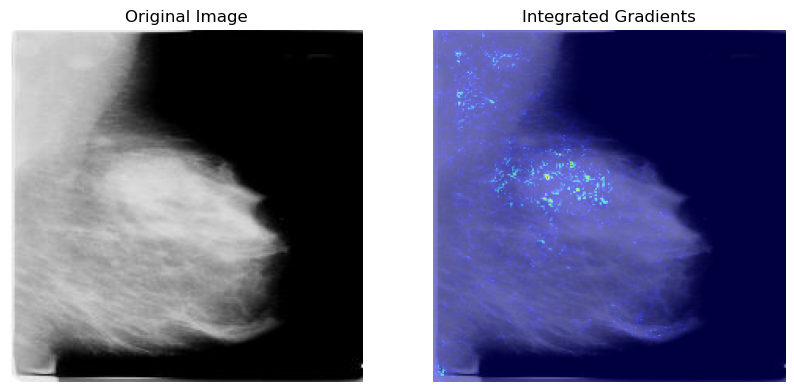

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Image 2: 328da68e5902493b9050145cdf0b2bcf_1-035_aug2502.jpg
  Actual:    Benign
  Predicted: Malignant (1.0000)


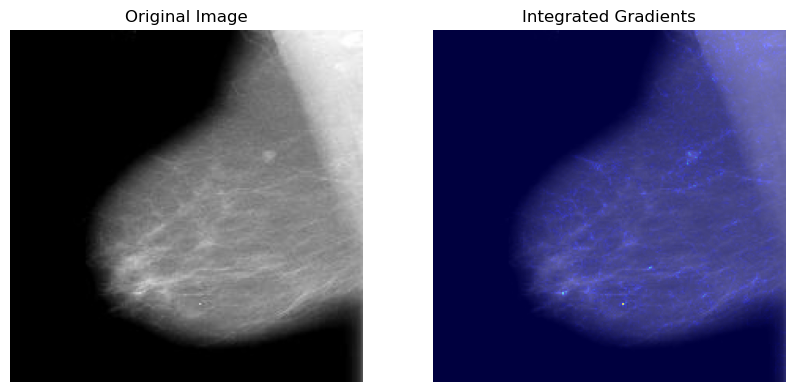

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import os
import random

# ========== CONFIG ==========
model_path = "pretrained_model/Resnet50.keras"
data_dir = r"C:\Users\Anne\OneDrive - National University of Ireland, Galway\Documents\Data Analytics\PROJECT\Capstone2025_Anne\kaggle\working\merged_images"
class_names = ["Benign", "Malignant"]
img_size = 224

# ===== LOAD MODEL =====
model = tf.keras.models.load_model(model_path)

# ===== LOAD RAW IMAGES =====
def load_images_from_folder(folder, max_images=5):
    image_paths = []
    for root, _, files in os.walk(folder):
        for fname in files:
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, fname))
    selected_paths = random.sample(image_paths, min(max_images, len(image_paths)))
    images = []
    for path in selected_paths:
        img = image.load_img(path, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        images.append(img_array)
    return np.array(images).astype(np.float32), selected_paths

X, paths = load_images_from_folder(data_dir, max_images=2)

# ===== Integrated Gradients Function =====
def integrated_gradients(inputs, model, target_class_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(inputs).astype(np.float32)
    
    # Scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i)/steps)*(inputs - baseline) for i in range(0, steps+1)]
    grads = []
    
    for scaled_input in scaled_inputs:
        scaled_input = tf.convert_to_tensor(scaled_input[None, ...])  # Add batch dim
        with tf.GradientTape() as tape:
            tape.watch(scaled_input)
            preds = model(preprocess_input(scaled_input))
            # Assuming model outputs probability for class "Malignant" (1)
            # Adjust loss for target_class_idx:
            if target_class_idx == 1:
                loss = preds[:, 0]       # Probability of malignant
            else:
                loss = 1 - preds[:, 0]   # Probability of benign (opposite)
        grad = tape.gradient(loss, scaled_input)[0].numpy()
        grads.append(grad)
    
    avg_grads = np.average(grads[:-1], axis=0)  # average gradients except last point
    integrated_grads = (inputs - baseline) * avg_grads  # element-wise product
    return integrated_grads

# ===== Normalize attributions =====
def normalize_attributions(attributions):
    min_val, max_val = attributions.min(), attributions.max()
    if max_val > min_val:
        return (attributions - min_val) / (max_val - min_val)
    else:
        return np.zeros_like(attributions)

# ===== Visualize Integrated Gradients =====
def plot_integrated_grads(img, ig, alpha=0.5):
    # Aggregate across channels by summing absolute values
    ig = np.sum(np.abs(ig), axis=-1)
    
    # Normalize attribution values to [0, 1]
    ig = normalize_attributions(ig)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))
    
    plt.subplot(1, 2, 2)
    plt.title("Integrated Gradients")
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))
    plt.imshow(ig, cmap='jet', alpha=alpha)
    
    plt.show()

# ===== Run and Plot IG for samples =====
for i, img in enumerate(X):
    # Get true class from folder name
    class_folder = os.path.basename(os.path.dirname(paths[i]))
    true_label = "Malignant" if class_folder == "1" else "Benign"
    
    # Predict
    img_input = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred_prob = model.predict(img_input)[0][0]
    pred_label = "Malignant" if pred_prob >= 0.5 else "Benign"
    
    # Compute IG for predicted class index (0=Benign, 1=Malignant)
    target_idx = 1 if pred_label == "Malignant" else 0
    
    # Integrated gradients
    ig = integrated_gradients(img, model, target_class_idx=target_idx, steps=50)
    
    print(f"Image {i+1}: {os.path.basename(paths[i])}")
    print(f"  Actual:    {true_label}")
    print(f"  Predicted: {pred_label} ({pred_prob:.4f})")
    
    plot_integrated_grads(img, ig)
